In [92]:
import os
import torch
import xml.etree.ElementTree as ET
import cv2 
import matplotlib.pyplot as plt
import matplotlib.patches as pac

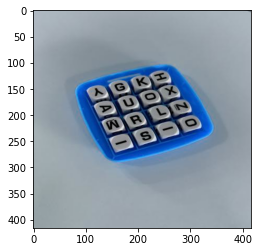

In [33]:
data_dir = "./boggle_boards/export"

_files = os.listdir(data_dir)

img = cv2.imread(os.path.join(data_dir, _files[0]))
plt.imshow(img)

In [97]:
def getImg(file, data_dir):
    return cv2.imread(os.path.join(data_dir, file)).flatten()

def getBBox(file, data_dir):
    tree = ET.parse(os.path.join(data_dir, _files[1]))
    objects = tree.getroot().findall('object')
    bbox = {
            o.find('name').text:
                 [
                    int(o.find('bndbox').find('xmin').text),
                    int(o.find('bndbox').find('xmax').text),
                    int(o.find('bndbox').find('ymin').text),
                    int(o.find('bndbox').find('ymax').text)
                    ] for o in objects
      }
    return bbox

def getData(files, data_dir):
    out = {}
    for file in files:
        name = file.split('.')[0]
        if name not in out.keys():
            out[name] = {'bbox':None, 'img':[]}
        if '.xml' in file:
            bb = getBBox(file, data_dir)
            out[name]['bbox'] = bb
        elif '.jpg' in file:
            img = getImg(file, data_dir)
            out[name]['img'] = img
    return out
    
def plotBB(image_key, all_data):
    plt.axes()
    plt.imshow(all_data[image_key]['img'].reshape(416, 416, 3))
    for bb in all_data[image_key]['bbox'].items():
            rectangle = pac.Rectangle(
                (bb[1][0], bb[1][2]),
                abs(bb[1][1] - bb[1][0]),
                abs(bb[1][3] - bb[1][2]),
                fc = 'none',
                ec="red")
            plt.gca().add_patch(rectangle)
    plt.show()    

In [98]:
all_data = getData(_files, data_dir)
print(all_data.keys())

dict_keys(['004d2c027e43dd194554d6527b4ba67a', '00a545913dc5c49d43ac2711bd534720', '01013b598023e4d8ea0a9775653ed2cb', '01987e86175023152b4c29b6372c731a', '037a42cd45dc61b2ba3ed4c5d372f047', '03affa0d60f7b85a18b30ad36a126ddc', '03d2c9ad216e0bc70c1122a8476722a4', '03e8b5f2b6eb063dde02423ecb7ff8f3', '044d5576e78542e2c3f07f414c3e6da4', '04dcdbd29ee6e8077089edee1e924672', '0527d05aa49312c5badd0dba07cb877c', '055c7b9679935e7ac13d76c5e90375a6', '0702f69309cc58386cdc31bd74af28b7', '072a98d28b44a01dfd4bdd0c5358668b', '0866c8ad6ef03a25f0fcc1d028c10403', '09e8afdd2087c5bb0bf94afffcd298f1', '0bb171a4ee437c2c7520fd247da6fc18', '0bb2b5bbc6c6696bc20f4c1808a67f89', '0c76fced49f544c9f33e44492aadf21f', '0e34806ff2787fba6d6f93f7ba618b68', '0ef968b9f502bbef2baa50f6d66e770a', '0f3a1731c795c477dfdcf4c80750079c', '106b51f1d2686b1d91ac3f9c4ee903c8', '1160ee71219ddd9b139cbe1b2470f033', '1176b8f46805664ca5424d3b576cdfce', '11a8258ed36df84ce2763ec1acee73cb', '12f33aab5f47ca0917cf86597a4c8f09', '131583bc83bd238e

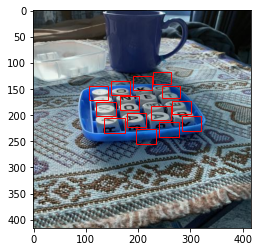

In [100]:


# plt.axes()
# plt.imshow(d['004d2c027e43dd194554d6527b4ba67a']['img'].reshape(416, 416, 3))
# for bb in d['004d2c027e43dd194554d6527b4ba67a']['bbox'].items():
#     # print(bb[0])
#     rectangle = pac.Rectangle((bb[1][0], bb[1][2]), abs(bb[1][1] - bb[1][0]), abs(bb[1][3] - bb[1][2]),fc = 'none',ec="red")
#     plt.gca().add_patch(rectangle)

# plt.show()
plotBB('01987e86175023152b4c29b6372c731a', all_data)

In [76]:
d['004d2c027e43dd194554d6527b4ba67a']['bbox']

{'y': [106, 142, 145, 171],
 'g': [148, 184, 135, 161],
 'k': [191, 226, 125, 151],
 'h': [228, 263, 117, 141],
 'a': [120, 157, 174, 201],
 'u': [165, 202, 163, 190],
 'o': [284, 320, 202, 230],
 'x': [245, 281, 144, 168],
 'm': [134, 174, 205, 235],
 'r': [178, 215, 195, 223],
 'l': [225, 263, 183, 210],
 'z': [265, 302, 172, 198],
 'i': [239, 278, 214, 242],
 's': [196, 235, 226, 256]}

In [34]:
print(_files[0], _files[1])
tree = ET.parse(os.path.join(data_dir, _files[1]))
# [k for k in tree.getroot()]
objects = tree.getroot().findall('object')
# {o.name: [o.xmax, o.xmin, o.ymax, o.ymin] for o in objects}
bbox = {
    o.find('name').text:
     [int(o.find('bndbox').find('xmin').text),
      int(o.find('bndbox').find('xmax').text),
      int(o.find('bndbox').find('ymin').text),
      int(o.find('bndbox').find('ymax').text)] for o in objects
      }
bbox

004d2c027e43dd194554d6527b4ba67a.jpg 004d2c027e43dd194554d6527b4ba67a.xml


{'y': [106, 142, 145, 171],
 'g': [148, 184, 135, 161],
 'k': [191, 226, 125, 151],
 'h': [228, 263, 117, 141],
 'a': [120, 157, 174, 201],
 'u': [165, 202, 163, 190],
 'o': [284, 320, 202, 230],
 'x': [245, 281, 144, 168],
 'm': [134, 174, 205, 235],
 'r': [178, 215, 195, 223],
 'l': [225, 263, 183, 210],
 'z': [265, 302, 172, 198],
 'i': [239, 278, 214, 242],
 's': [196, 235, 226, 256]}

In [35]:
_files[0].split('.')

['004d2c027e43dd194554d6527b4ba67a', 'jpg']